## Feature compression

In [2]:
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pickle
from sklearn.decomposition import PCA, KernelPCA
from scipy.fftpack import dct, idct
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import spearmanr

from sklearn.linear_model import Lasso, LassoCV, LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold

In [6]:
from scipy.fftpack import dct, idct
import numpy as np

def iDCTquant(v,n):
    f = dct(v.T, type=2, norm='ortho')
    trans = idct(f[:,:n], type=2, norm='ortho')
    for i in range(len(trans)):
        trans[i] = scale(trans[i])
    return trans.T

def scale(v):
    M = np.max(v)
    m = np.min(v)
    return (v - m) / float(M - m)

def quant2D(emb,n=5,m=44):
    dct = iDCTquant(emb[1:len(emb)-1],n)
    ddct = iDCTquant(dct.T,m).T
    ddct = ddct.reshape(n*m)
    return (ddct*127).astype('int8')

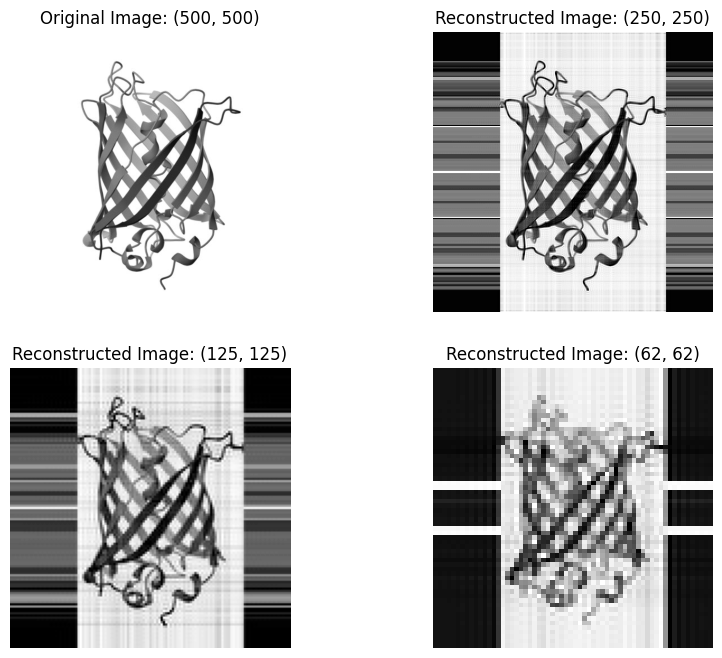

In [8]:
#################################### iDCT Adapted version #########################################
def iDCTquant(v,n):
    f = dct(v.T, type=2, norm='ortho')
    trans = idct(f[:,:n], type=2, norm='ortho')
    for i in range(len(trans)):
        trans[i] = scale(trans[i])
    return trans.T

def scale(v):
    M = np.max(v)
    m = np.min(v)
    return (v - m) / float(M - m)

def quant2D(emb,n=5,m=44):
    dct = iDCTquant(emb[1:len(emb)-1],n)
    ddct = iDCTquant(dct.T,m).T
    #ddct = ddct.reshape(n*m)
    return (ddct*127).astype('int8')




# Load an image (you can replace this with your own image file)
image = plt.imread('1gfl_GFP_PDB.jpeg')

# Convert the image to grayscale
image = np.mean(image, axis=2)

n=125
m=125

recon1 = quant2D(image,250,250)
recon2 = quant2D(image,n,m)
recon3 = quant2D(image,62,62)

# Plot the original image and the reconstructed image
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0,0].imshow(image, cmap='gray')
axs[0,0].set_title(f'Original Image: {image.shape}')
axs[0,0].axis('off')

axs[0,1].imshow(recon1, cmap='gray')
axs[0,1].set_title(f'Reconstructed Image: {recon1.shape}')
axs[0,1].axis('off')


axs[1,0].imshow(recon2, cmap='gray')
axs[1,0].set_title(f'Reconstructed Image: {recon2.shape}')
axs[1,0].axis('off')

axs[1,1].imshow(recon3, cmap='gray')
axs[1,1].set_title(f'Reconstructed Image: {recon3.shape}')
axs[1,1].axis('off')

#plt.savefig('banner.png', dpi=300)
plt.show()

In [3]:
def features_scaler(features):
    '''Scale the features by min-max scaler, to ensure that the features selected by Lasso are not biased by the scale of the features.
    Also, the features are scaled across the rows, i.e., the features are scaled across the sequence length.'''
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    scaled_features = scaler.fit_transform(features)
    return pd.DataFrame(scaled_features)

def pca_transformation(embeddings, num_pca_components=2):
    '''Transform the embeddings using PCA.
    First I transposed the embeddings, because PCA works on the features, not on the samples.
    So my features will be the sequence length and the samples will be the model dimensions.
    After PCA, I transposed the embeddings back to obtain a single vector of the transformed embeddings,
    each row will represented by a pca of model dimentsions'''
    features = features_scaler(embeddings).T
    pca = PCA(num_pca_components)
    embed_trans = pca.fit_transform(features)
    return embed_trans.T

def kernel_pca_rbf_transformation(embeddings, num_pca_components=2):
    '''Transform the embeddings using kernel PCA'''
    features = features_scaler(embeddings).T
    kpca_rbf = KernelPCA(kernel="rbf", gamma=None, n_components=num_pca_components, n_jobs=16)
    kpca_rbf_features = kpca_rbf.fit_transform(features)
    return kpca_rbf_features.T

def kernel_pca_sigmoid_transformation(embeddings, num_pca_components=2):
    '''Transform the embeddings using kernel PCA'''
    features = features_scaler(embeddings).T
    kpca_sigmoid = KernelPCA(kernel="sigmoid", gamma=None, n_components=num_pca_components, n_jobs=16)
    kpca_sigmoid_features = kpca_sigmoid.fit_transform(features)
    return kpca_sigmoid_features.T

def tSNE_transformation(embeddings, num_pca_components=2):
    '''Transform the embeddings using tSNE'''
    features = features_scaler(embeddings).T
    tSNE_model = TSNE(n_components=num_pca_components, n_jobs=16, metric='cosine')
    tSNE_features = tSNE_model.fit_transform(features)
    return tSNE_features.T



def iDCTquant(v,n):
    f = dct(v.T, type=2, norm='ortho')
    trans = idct(f[:,:n], type=2, norm='ortho')
    return trans.T

def quant2D(emb, n=64, m=80): # final vector length 5120
    dct = iDCTquant(emb,n)
    ddct = iDCTquant(dct.T,m).T
    ddct = ddct.reshape(n*m) # turn a 2D array into a 1D vector
    return ddct
    

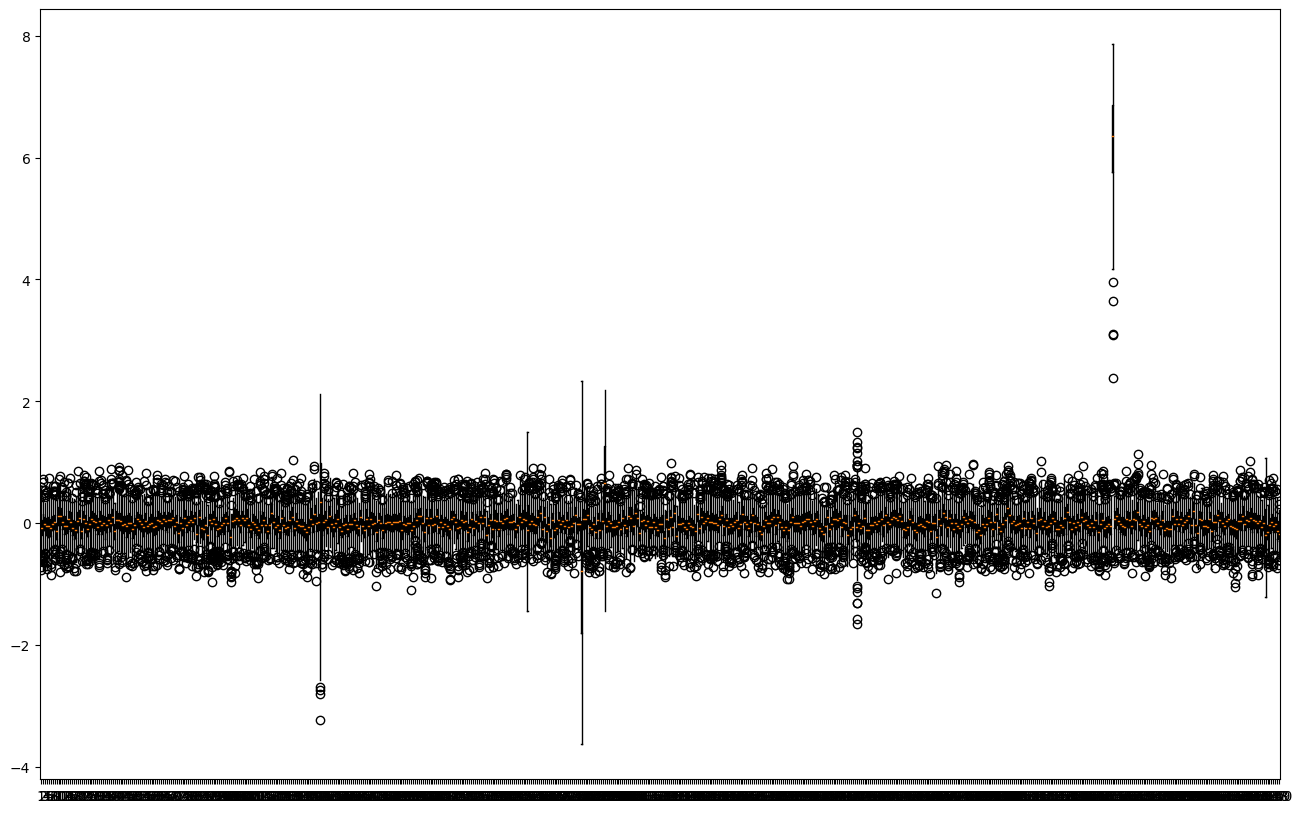

In [23]:
plt.figure(figsize=(16, 10))
mtx = torch.load('embeddings/AMIE_PSEAE_Whitehead_esm2_150M/AMIE_PSEAE_A16A.pt')['representations'][30].numpy()
plt.boxplot(mtx)
plt.show()

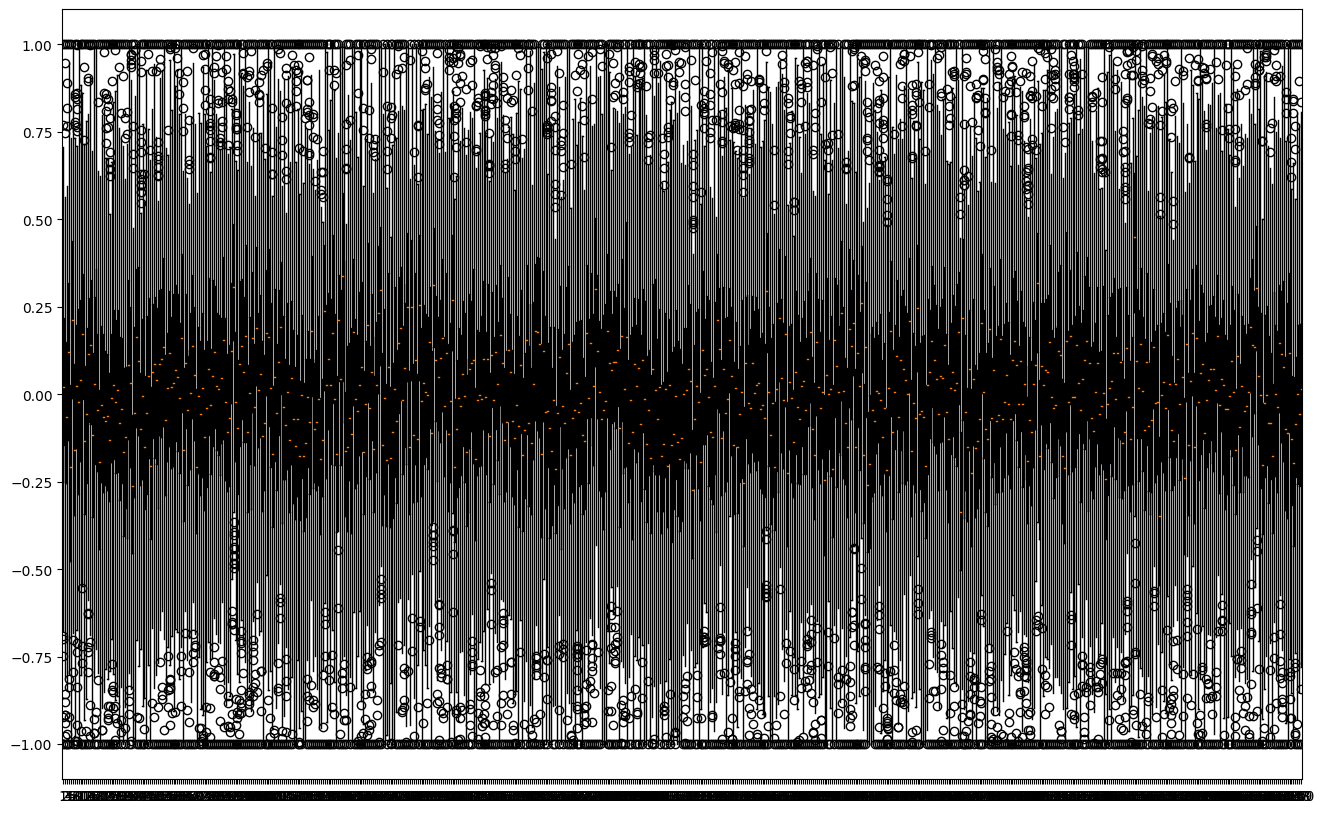

In [22]:
plt.figure(figsize=(16, 10))
mtx = torch.load('embeddings/AMIE_PSEAE_Whitehead_esm2_150M/AMIE_PSEAE_A16A.pt')['representations'][30].numpy()
plt.boxplot(features_scaler(mtx))
plt.show()

In [4]:
def load_per_tok_embeds(dir_path, compression_method, rep_layer=30):
    embeddings = {}
    count=0
    for file in os.listdir(dir_path):
        if file.endswith('.pt'):
            file_path = os.path.join(dir_path, file)
            label = file.split('.pt')[0]

            if compression_method == 'mean':
                embed = np.array(torch.load(file_path)['mean_representations'][rep_layer])
                embeddings[label] = embed

            elif compression_method == 'bos':
                embed = np.array(torch.load(file_path)['bos_representations'][rep_layer])
                embeddings[label] = embed

            elif compression_method == 'maxPool':
                embed = np.array(torch.load(file_path)['representations'][rep_layer])
                embed_trans = embed.max(axis=0)
                embeddings[label] = embed_trans

            elif compression_method == 'pca1':
                embed = np.array(torch.load(file_path)['representations'][rep_layer])
                embed_trans = pca_transformation(embed)
                embeddings[label] = embed_trans[0] # zero select onle the  first pca component

            elif compression_method == 'pca2':
                embed = np.array(torch.load(file_path)['representations'][rep_layer])
                embed_trans = pca_transformation(embed)
                embeddings[label] = embed_trans[1] # one select onle the  second pca component

            elif compression_method == 'pca1-2':
                embed = np.array(torch.load(file_path)['representations'][rep_layer])
                embed_trans = pca_transformation(embed)
                embeddings[label] = embed_trans.reshape(-1)

            elif compression_method == 'rbf1':
                embed = np.array(torch.load(file_path)['representations'][rep_layer])
                embed_trans = kernel_pca_rbf_transformation(embed)
                embeddings[label] = embed_trans[0]

            elif compression_method == 'rbf2':
                embed = np.array(torch.load(file_path)['representations'][rep_layer])
                embed_trans = kernel_pca_rbf_transformation(embed)
                embeddings[label] = embed_trans[1]

            elif compression_method == 'sigmoid1':
                embed = np.array(torch.load(file_path)['representations'][rep_layer])
                embed_trans = kernel_pca_sigmoid_transformation(embed)
                embeddings[label] = embed_trans[0]

            elif compression_method == 'sigmoid2':
                embed = np.array(torch.load(file_path)['representations'][rep_layer])
                embed_trans = kernel_pca_sigmoid_transformation(embed)
                embeddings[label] = embed_trans[1]

            elif compression_method == 'iDCT':
                embed = np.array(torch.load(file_path)['representations'][rep_layer])
                embeddings[label] = quant2D(embed)
                
        
            else:
                raise ValueError('Invalid compression method')
                print('Valid compression methods are: mean, bos, max_pool, pca1, pca2, pca1-2, rbf1, rbf2, sigmoid1, sigmoid2')
          

        count+=1
        if count % 100 == 0:
            print(f'{count} files compressed')

    return embeddings

In [ ]:
dir_path = 'embeddings/BLAT_ECOLX_Ostermeier2014_esm2_150M/'
#for i in ['mean', 'bos', 'max_pool', 'pca1', 'pca2', 'pca1-2', 'iDCT', 'rbf1', 'sigmoid1']:
for i in ['linear']:
    print(f'Compressing embeddings using {i}')
    embed = load_per_tok_embeds(dir_path, i)
    #with open(f'embeddings/BLAT_ECOLX_Ostermeier2014_esm2_150M_compressed/BLAT_ECOLX_Ostermeier2014_esm2_150M_{i}.pkl', 'wb') as f:
    #with open(f'embeddings/BLAT_ECOLX_Ostermeier2014_esm2_150M_compressed/embed_layer_30_linear.pkl', 'wb') as f:
        #pickle.dump(embed, f)

In [82]:
def run_regression(features, target):
    '''this version computes y_pred for train and test sets'''
    # Initialize lists for storing results
    folds, num_nonzero_coefs = [], []
    r2s_train, maes_train, rmses_train = [], [], []
    r2s_test, maes_test, rmses_test = [], [], []
    rhos_train, rhos_test = [], []

    # Define the KFold cross-validator
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    # Loop over the KFold splits
    for kfold, (train_index, test_index) in enumerate(kf.split(features)):
        # Split the data into training and testing sets
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]

        # Define and train the regression model
        model = Lasso(alpha=0.001, random_state=42, max_iter=10000, tol=0.001)
        #model = Lasso(alpha=0.0005, random_state=42, max_iter=10000, tol=0.001)
        model.fit(X_train, y_train)

        # get the number of non-zero coefficients
        coeficients = model.coef_
        num_nonzero_coef = np.sum(coeficients != 0)

        # Make predictions
        y_pred_train = pd.DataFrame(model.predict(X_train))
        y_pred_test = pd.DataFrame(model.predict(X_test))

        # Evaluate the model
        r2_train = metrics.r2_score(y_train, y_pred_train)
        mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
        mse_train = metrics.mean_squared_error(y_train, y_pred_train)
        rmse_train = np.sqrt(mse_train)
        rho_train, p_value_train = spearmanr(y_train, y_pred_train)

        r2_test = metrics.r2_score(y_test, y_pred_test)
        mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
        mse_test = metrics.mean_squared_error(y_test, y_pred_test)
        rmse_test = np.sqrt(mse_test)
        rho_test, p_value_test = spearmanr(y_test, y_pred_test)

        # Append results
        r2s_train.append(r2_train)
        maes_train.append(mae_train)
        rmses_train.append(rmse_train)

        r2s_test.append(r2_test)
        maes_test.append(mae_test)
        rmses_test.append(rmse_test)

        rhos_train.append(rho_train)
        rhos_test.append(rho_test)

        folds.append(kfold + 1)
        num_nonzero_coefs.append(num_nonzero_coef)


        # Return the collected results
        #print(f"Results:  fold {kfold}, r2_test: {r2_test}, Num coefs: {num_nonzero_coef}")
    return r2s_train, maes_train, rmses_train, r2s_test, maes_test, rmses_test, rhos_train, rhos_test, folds, num_nonzero_coefs


def save_results(r2s_train, maes_train, rmses_train, r2s_test, maes_test, rmses_test, rhos_train, rhos_test, folds, num_nonzero_coefs):
    # Create dictionary for results
    res_dict = {
        "Model": ['Lasso'] * 10,
        "Fold": folds,
        "R2_score_train": r2s_train,
        "MAE_score_train": maes_train,
        "RMSE_score_train": rmses_train,
        "R2_score_test": r2s_test,
        "MAE_score_test": maes_test,
        "RMSE_score_test": rmses_test,
        "rho_score_train": rhos_train,
        "rho_score_test": rhos_test,

        "nun_zero_coefs": num_nonzero_coefs
    }

    # Convert results to DataFrame
    results = pd.DataFrame(res_dict).reset_index(drop=True)
    return results



def run_regression_on_compressed_files(path_compressed_embeds, path_meta_data):
    '''Run regression on compressed embeddings'''
    meta_data = pd.read_csv(path_meta_data)

    results = pd.DataFrame()
    for file in os.listdir(path_compressed_embeds):
        if file.endswith('.pkl') and 'iDCT' in file or 'mean' in file:
            method = file.split('_')[-1].split('.')[0]
            print('Results for method:', method)
            file_path = os.path.join(path_compressed_embeds, file)
            embed = pd.read_pickle(file_path)
            embed_df = pd.DataFrame.from_dict(embed, orient='index').reset_index()
            embed_df.rename(columns={'index': 'ID'}, inplace=True)

            data = meta_data.merge(embed_df, how='inner', left_on='ID', right_on='ID')
            target = data['target']
            features = data.iloc[:, meta_data.shape[1]:]
            features = features_scaler(features)

            # run regression
            r2s_train, maes_train, rmses_train, r2s_test, maes_test, rmses_test, rhos_train, rhos_test, folds, num_nonzero_coefs = run_regression(features, target)
            res = save_results(r2s_train, maes_train, rmses_train, r2s_test, maes_test, rmses_test, rhos_train, rhos_test, folds, num_nonzero_coefs)
            res['Compression_methd'] = method
            results = pd.concat([results, res], axis=0)

    return results


In [18]:
# df = pd.read_csv('data/sumo1_human_metadata.csv', index_col=0)#[['ID', 'Mutation', 'MIC_Score', 'sequences']]
# df.rename(columns={'screen.score':'Target'}, inplace=True)
# df.to_csv('data/sumo1_human_metadata_v02.csv', index=False)

## Testing Feature compression on DMS datasets
### BLAT_ECOLX_Ostermeier2014

In [ ]:
target_name = 'target'
path_compressed_embed = 'embeddings/BLAT_ECOLX_Ostermeier2014_esm2_150M_compressed/'
path_meta_data = 'data/metadata/BLAT_ECOLX_Ostermeier2014_metadata.csv'
results = run_regression_on_compressed_files(path_compressed_embed, path_meta_data)
results

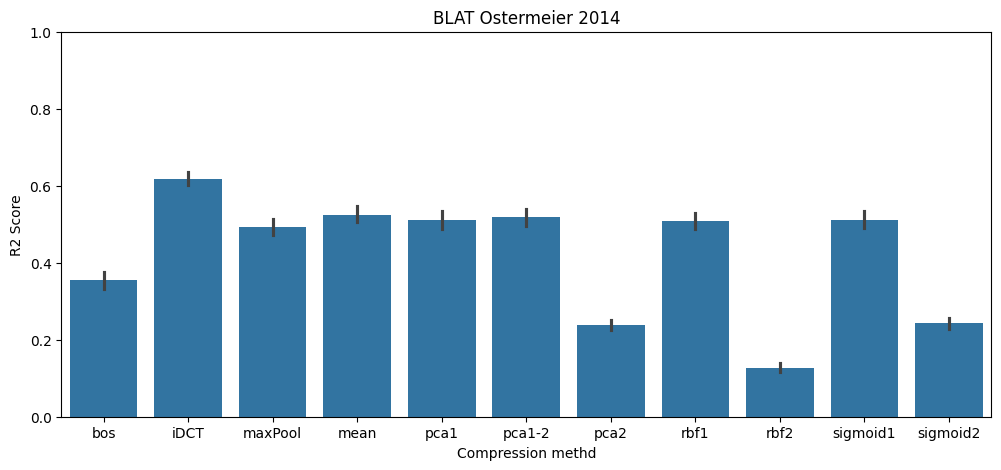

In [8]:
results.sort_values('Compression_methd', inplace=True)

plt.figure(figsize=(12, 5))
sns.barplot(data=results, x='Compression_methd', y='R2_score_test')
plt.title('BLAT Ostermeier 2014')
plt.ylim(0, 1)
plt.ylabel('R2 Score')
plt.xlabel('Compression methd')
plt.show()

In [6]:
target_name = 'target'
path_compressed_embed = 'embeddings/BRCA1_HUMAN_RING_esm2_150M_compressed/'
path_meta_data = 'data/metadata/BRCA1_HUMAN_RING_metadata.csv'
results = run_regression_on_compressed_files(path_compressed_embed, path_meta_data)
results

Results for method: mean
Results for method: iDCT
Results for method: rbf1
Results for method: pca1-2
Results for method: sigmoid1
Results for method: pca2
Results for method: pca1
Results for method: maxPool
Results for method: sigmoid2
Results for method: rbf2


/stor/work/Wilke/luiz/DMS_iDCT/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.289e+00, tolerance: 5.072e-01
  model = cd_fast.enet_coordinate_descent(
/stor/work/Wilke/luiz/DMS_iDCT/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.283e+00, tolerance: 4.974e-01
  model = cd_fast.enet_coordinate_descent(
/stor/work/Wilke/luiz/DMS_iDCT/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consi

Results for method: bos
Results for method: iDCT2


,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_methd
0,Lasso,1,0.773669,0.307722,0.416437,0.538549,0.409387,0.605802,0.722519,0.718020,178,mean
1,Lasso,2,0.772646,0.307328,0.413330,0.624663,0.396758,0.595210,0.739552,0.719988,174,mean
2,Lasso,3,0.775674,0.303261,0.407261,0.579998,0.482762,0.662992,0.739175,0.751215,168,mean
3,Lasso,4,0.779905,0.315740,0.417536,0.637379,0.325993,0.456542,0.748596,0.638890,191,mean
4,Lasso,5,0.798281,0.296461,0.397510,0.415282,0.473284,0.622448,0.747891,0.495229,184,mean
...,...,...,...,...,...,...,...,...,...,...,...,...
5,Lasso,6,0.899346,0.204687,0.276212,0.425245,0.531241,0.713186,0.847431,0.582680,287,iDCT2
6,Lasso,7,0.904140,0.208017,0.273535,0.225683,0.469244,0.721883,0.858673,0.386612,281,iDCT2
7,Lasso,8,0.885307,0.214277,0.293952,0.673759,0.394441,0.550673,0.835994,0.609170,287,iDCT2
8,Lasso,9,0.897171,0.210845,0.284861,0.509431,0.407461,0.538160,0.851547,0.519471,305,iDCT2


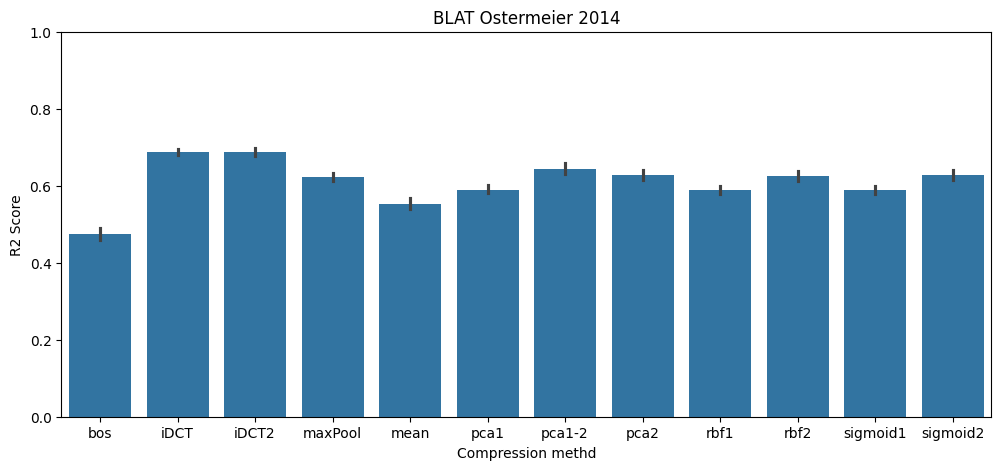

In [12]:
results.sort_values('Compression_methd', inplace=True)

plt.figure(figsize=(12, 5))
sns.barplot(data=results, x='Compression_methd', y='rho_score_test')
plt.title('BLAT Ostermeier 2014')
plt.ylim(0, 1)
plt.ylabel('R2 Score')
plt.xlabel('Compression methd')
plt.show()

In [10]:
target_name = 'target'
path_compressed_embed = 'embeddings/AMIE_PSEAE_Whitehead_esm2_150M_compressed/'
path_meta_data = 'data/metadata/AMIE_PSEAE_Whitehead_metadata.csv'
results = run_regression_on_compressed_files(path_compressed_embed, path_meta_data)
results

Results for method: iDCT
Results for method: rbf1
Results for method: mean
Results for method: maxPool
Results for method: sigmoid1
Results for method: pca2
Results for method: pca1-2
Results for method: iDCT2
Results for method: sigmoid2
Results for method: pca1
Results for method: bos
Results for method: rbf2


,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_methd
0,Lasso,1,0.469038,0.210143,0.275153,0.410093,0.226360,0.302267,0.731548,0.688619,271,iDCT
1,Lasso,2,0.471530,0.210183,0.275406,0.384897,0.218698,0.300191,0.731791,0.684398,255,iDCT
2,Lasso,3,0.464432,0.211561,0.277068,0.428398,0.217372,0.290958,0.728075,0.693992,258,iDCT
3,Lasso,4,0.471576,0.210336,0.276548,0.409403,0.223145,0.281810,0.733751,0.681495,262,iDCT
4,Lasso,5,0.470713,0.209617,0.274458,0.398334,0.231513,0.307712,0.734108,0.666812,253,iDCT
...,...,...,...,...,...,...,...,...,...,...,...,...
5,Lasso,6,0.395148,0.227207,0.294122,0.324069,0.246810,0.319301,0.657569,0.627249,164,rbf2
6,Lasso,7,0.396145,0.229388,0.296328,0.333801,0.228297,0.293606,0.661152,0.613230,168,rbf2
7,Lasso,8,0.391645,0.230181,0.296243,0.360717,0.228711,0.298868,0.656043,0.646383,165,rbf2
8,Lasso,9,0.392215,0.229645,0.295939,0.352639,0.235496,0.302517,0.663358,0.612712,167,rbf2


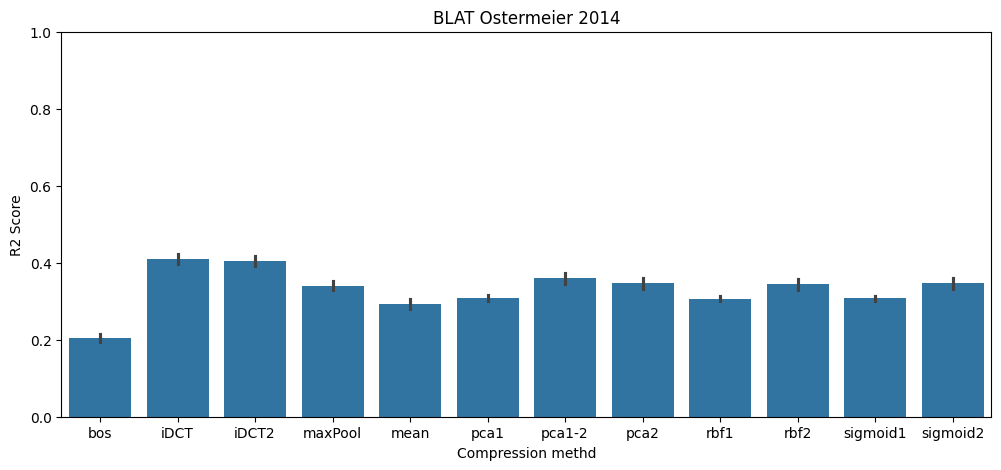

In [11]:
results.sort_values('Compression_methd', inplace=True)

plt.figure(figsize=(12, 5))
sns.barplot(data=results, x='Compression_methd', y='R2_score_test')
plt.title('BLAT Ostermeier 2014')
plt.ylim(0, 1)
plt.ylabel('R2 Score')
plt.xlabel('Compression methd')
plt.show()

## Classification

## cov2_ace2

In [12]:
meta_data = pd.read_csv('data/cov2_ace2_bind_all_metadata.csv', index_col=0)
n= 1350
meta_data = meta_data.groupby('log_fitness', group_keys=False).apply(lambda x: x.sample(n) if len(x) > n else pd.DataFrame())
meta_data['log_fitness'].value_counts()

log_fitness
0    1350
1    1350
Name: count, dtype: int64

In [13]:
def run_Log_regression(features, target, target_name, num_classes):
    # Initialize lists for storing results
    folds = []
    accuracies_train, recalls_train, precisions_train, f1_scores_train = [], [], [], []
    accuracies_test, recalls_test, precisions_test, f1_scores_test = [], [], [], []
    coefs = []

    # Define the KFold cross-validator
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    # Loop over the KFold splits
    for kfold, (train_index, test_index) in enumerate(kf.split(features)):
        # Split the data into training and testing sets
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]

        # Define and train the regression model
        model = LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear')
        model.fit(X_train, y_train)

        # Make predictions
        y_pred_train = pd.DataFrame(model.predict(X_train))
        y_pred_test = pd.DataFrame(model.predict(X_test))

        # get the number of non-zero coefficients
        coefficients = model.coef_
        coefs.append(np.sum(coefficients != 0))

        # Evaluate the model on overall metrics
        accuracy_train = metrics.accuracy_score(y_train, y_pred_train)
        recall_train = metrics.recall_score(y_train, y_pred_train)
        precision_train = metrics.precision_score(y_train, y_pred_train)
        f1_score_train = metrics.f1_score(y_train, y_pred_train)

        accuracy_test = metrics.accuracy_score(y_test, y_pred_test)
        recall_test = metrics.recall_score(y_test, y_pred_test)
        precision_test = metrics.precision_score(y_test, y_pred_test)
        f1_score_test = metrics.f1_score(y_test, y_pred_test)

        print(f"Results for {target_name},  fold {kfold}, accuracy_test: {accuracy_test}, recall_test: {recall_test}, precision_test: {precision_test}, f1_score_test: {f1_score_test}, Num coefs: {coefs}")
       
        # Append results
        accuracies_train.append(accuracy_train)
        recalls_train.append(recall_train)
        precisions_train.append(precision_train)
        f1_scores_train.append(f1_score_train)

        accuracies_test.append(accuracy_test)
        recalls_test.append(recall_test)
        precisions_test.append(precision_test)
        f1_scores_test.append(f1_score_test)


        folds.append(kfold + 1)
    # Return the collected results
    return accuracies_train, recalls_train, precisions_train, f1_scores_train, accuracies_test, recalls_test, precisions_test, f1_scores_test, folds, coefs


def save_results(layer, accuracies_train, recalls_train, precisions_train, f1_scores_train, accuracies_test, recalls_test, precisions_test, f1_scores_test, folds, coefs):
    # Create dictionary for results
    res_dict = {
        "Layer": [layer] * 10,
        "Model": ['LogR'] * 10,
        "Fold": folds,
        "Accuracy_train": accuracies_train,
        "Recall_train": recalls_train,
        "Precision_train": precisions_train,
        "F1_score_train": f1_scores_train,
        "Accuracy_test": accuracies_test,
        "Recall_test": recalls_test,
        "Precision_test": precisions_test,
        "F1_score_test": f1_scores_test,
        "num_non_zero_coefs": coefs
    }

    # Convert results to DataFrame
    results = pd.DataFrame(res_dict).reset_index(drop=True)
    return results


In [ ]:
path = 'embeddings/cov2_ace2_esm2_150M_compressed'
layer = 30
target_name = 'log_fitness'
results = pd.DataFrame()
for file in os.listdir(path):
    if file.endswith('.pkl') and file not in ['embed_layer_30_tSNE.pkl']:
        method = file.split('_')[-1].split('.')[0]
        print('Results for method:', method)
        file_path = os.path.join(path, file)
        embeds = pd.read_pickle(file_path)
        data = meta_data.merge(embeds, how='inner', left_on='ID', right_on='ID')
        target = data[target_name]
        features = data.iloc[:, meta_data.shape[1]:]
        features = features_scaler(features)
     
        # run classification
        accuracies_train, recalls_train, precisions_train, f1_scores_train, accuracies_test, recalls_test, precisions_test, f1_scores_test, folds, coefs = run_Log_regression(features, target, target_name, 2)
        res = save_results(layer, accuracies_train, recalls_train, precisions_train, f1_scores_train, accuracies_test, recalls_test, precisions_test, f1_scores_test, folds, coefs)
        res['Compression_methd'] = method
        results = pd.concat([results, res], axis=0)

In [19]:
#results.to_csv('results/classification/compression/cov2_ace2_esm2_150M_layer_30_compressed.csv', index=False)
results = pd.read_csv('results/classification/compression/cov2_ace2_esm2_150M_layer_30_compressed.csv')
results.sort_values('Compression_methd', inplace=True)
results

,Layer,Model,Fold,Accuracy_train,Recall_train,Precision_train,F1_score_train,Accuracy_test,Recall_test,Precision_test,F1_score_test,num_non_zero_coefs,Compression_methd
0,30,LogR,10,0.899588,0.904921,0.893004,0.898923,0.892593,0.900662,0.906667,0.903654,152,bos
1,30,LogR,1,0.907407,0.916803,0.901363,0.909017,0.851852,0.870968,0.818182,0.843750,158,bos
2,30,LogR,2,0.905761,0.915980,0.897498,0.906645,0.862963,0.845588,0.877863,0.861423,160,bos
3,30,LogR,3,0.903704,0.913079,0.895292,0.904098,0.866667,0.866197,0.878571,0.872340,151,bos
4,30,LogR,4,0.899588,0.912829,0.889423,0.900974,0.885185,0.858209,0.905512,0.881226,158,bos
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,30,LogR,10,0.920988,0.929108,0.912367,0.920661,0.907407,0.900662,0.931507,0.915825,149,sigmoid
65,30,LogR,7,0.924691,0.933443,0.917609,0.925458,0.885185,0.894737,0.875000,0.884758,148,sigmoid
66,30,LogR,8,0.927160,0.936170,0.920354,0.928195,0.892593,0.898438,0.877863,0.888031,140,sigmoid
67,30,LogR,9,0.921399,0.929038,0.916331,0.922641,0.900000,0.935484,0.859259,0.895753,144,sigmoid


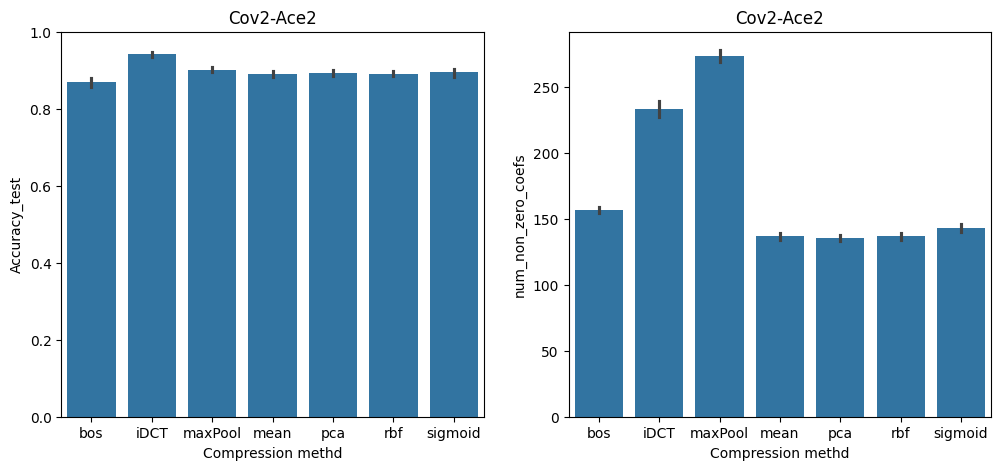

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(data=results, x='Compression_methd', y='Accuracy_test', ax=ax[0])
ax[0].set_title('Cov2-Ace2')
ax[0].set_ylim(0, 1)
ax[0].set_ylabel('Accuracy_test')
ax[0].set_xlabel('Compression methd')

sns.barplot(data=results, x='Compression_methd', y='num_non_zero_coefs', ax=ax[1])
ax[1].set_title('Cov2-Ace2')
#ax[1].set_ylim(0, 1)
ax[1].set_ylabel('num_non_zero_coefs')
ax[1].set_xlabel('Compression methd')
plt.show()

## Testing Feature compression on diverse datasets

In [16]:
def randomly_delete_zeros(df, column, retain_percentage=0.10):
    # Ensure column exists in DataFrame
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame.")

    # Identify zero entries
    zero_indices = df[df[column] == 0].index

    # Calculate the number of zeros to delete
    n_delete = len(zero_indices) - int(len(zero_indices) * retain_percentage)

    # Check if there's anything to delete
    if n_delete <= 0:
        return df

    # Randomly select indices to delete
    indices_to_delete = np.random.choice(zero_indices, n_delete, replace=False)

    # Delete these indices from the DataFrame and return
    return df.drop(indices_to_delete)


In [20]:
# creating meta_data for pisces datasets: ss_H
meta_data = pd.read_csv('data/meta_data/pisces_meta_data_SS.csv')
meta_data = randomly_delete_zeros(meta_data, 'ss_H', retain_percentage=0.10)
meta_data.rename(columns={'ss_H': 'target'}, inplace=True)
meta_data[['ID', 'target', 'sequence']].to_csv('data/meta_data/pisces_meta_data_ss_H.csv', index=False)

In [31]:
# creating meta_data for pisces datasets: Leucina frequency
meta_data = pd.read_csv('data/meta_data/pisces_meta_data_PCP.csv')
meta_data.rename(columns={'L_freq': 'target'}, inplace=True)
meta_data[['ID', 'target', 'sequence']].to_csv('data/meta_data/pisces_meta_data_freq_Leu.csv', index=False)

In [35]:
# creating meta_data for pisces datasets: Instability_index
meta_data = pd.read_csv('data/meta_data/pisces_meta_data_PCP.csv')
meta_data.rename(columns={'Instability_index': 'target'}, inplace=True)
meta_data[['ID', 'target', 'sequence']].to_csv('data/meta_data/pisces_meta_data_PCP_Instability_index.csv', index=False)

In [39]:
# creating meta_data for pisces datasets: hidrophobicity
meta_data = pd.read_csv('data/meta_data/pisces_meta_data_PCP.csv')
meta_data.rename(columns={'Hydrophobicity': 'target'}, inplace=True)
meta_data[['ID', 'target', 'sequence']].to_csv('data/meta_data/pisces_meta_data_PCP_Hydrophobicity.csv', index=False)

In [26]:
target_name = 'target'
path_compressed_embed = 'embeddings/pisces_esm2_150M_compressed/'
path_meta_data = 'data/meta_data/pisces_meta_data_ss_H.csv'
results = run_regression_on_compressed_files(path_compressed_embed, path_meta_data)
results

,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_methd
8,Lasso,9,0.617577,0.096456,0.123778,0.615170,0.097775,0.126122,0.760713,0.771842,156,bos
1,Lasso,2,0.621116,0.096137,0.123354,0.607490,0.098542,0.126006,0.763686,0.745829,151,bos
2,Lasso,3,0.620456,0.096419,0.123678,0.614983,0.096003,0.122802,0.762848,0.755113,155,bos
3,Lasso,4,0.622564,0.096232,0.123396,0.599494,0.096893,0.124701,0.763967,0.744500,152,bos
4,Lasso,5,0.619577,0.096320,0.123462,0.612823,0.098402,0.126452,0.761127,0.756176,155,bos
...,...,...,...,...,...,...,...,...,...,...,...,...
4,Lasso,5,0.383870,0.120524,0.157122,0.394715,0.121499,0.158107,0.569796,0.599876,100,sigmoid2
0,Lasso,1,0.393982,0.119586,0.155959,0.337866,0.125055,0.164104,0.577579,0.540504,102,sigmoid2
2,Lasso,3,0.387909,0.120298,0.157061,0.388540,0.120226,0.154757,0.577417,0.553060,102,sigmoid2
1,Lasso,2,0.384005,0.120627,0.157285,0.398585,0.120799,0.155974,0.573571,0.575004,102,sigmoid2


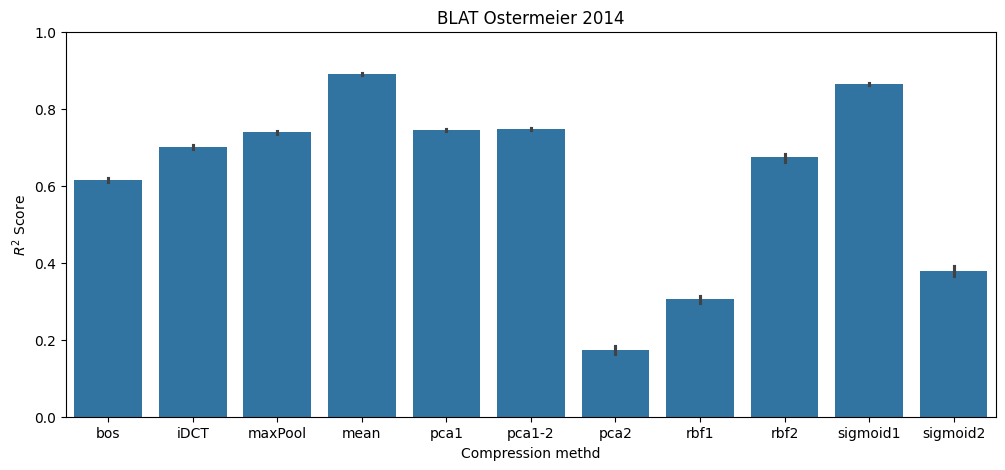

In [25]:
results.sort_values('Compression_methd', inplace=True)

plt.figure(figsize=(12, 5))
sns.barplot(data=results, x='Compression_methd', y='R2_score_test')
plt.title('BLAT Ostermeier 2014')
plt.ylim(0, 1)
plt.ylabel('$R^{2}$ Score')
plt.xlabel('Compression methd')
plt.show()